# Method 9 - Best Fresh Ideas

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Fresh Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Best

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter to Fresh

best_ideas = best_ideas.merge(flat_qty).merge(flat_pos_size)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
# Backtest the Portfolio

w = weights.Weights(best_ideas)

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

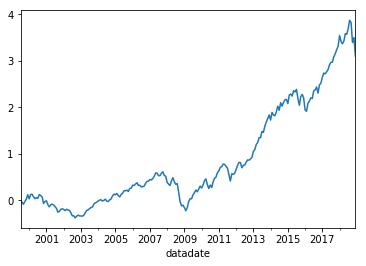

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.118051
2000-12-31   -0.130155
2001-12-31   -0.160224
2002-12-31   -0.189916
2003-12-31    0.444641
2004-12-31    0.182698
2005-12-31    0.114300
2006-12-31    0.119083
2007-12-31    0.076756
2008-12-31   -0.411657
2009-12-31    0.459451
2010-12-31    0.221088
2011-12-31   -0.009090
2012-12-31    0.217906
2013-12-31    0.475699
2014-12-31    0.118937
2015-12-31    0.009368
2016-12-31    0.099436
2017-12-31    0.226198
2018-12-31   -0.049073
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     769.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.93e-131
Time:                        20:57:16   Log-Likelihood:                 698.82
No. Observations:                 234   AIC:                            -1388.
Df Residuals:                     229   BIC:                            -1370.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.579      0.011       0.001       0.004
mktrf          0.9943      0.023     43.184      0.000       0.949       1.040
me             0.2145      0.027      8.008      0.000       0.162       0.267
ia            -0.0623      0.041     -1.532      0.127      -0.143       0.018
roe            0.0795      0.035      2.281      0.023       0.011       0.148
==============================================================================
Omnibus:                       29.715   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.805
Skew:                          -0.687   Prob(JB):                     3.42e-12
Kurtosis:                       4.878   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     862.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.71e-137
Time:                        20:57:16   Log-Likelihood:                 698.82
No. Observations:                 234   AIC:                            -1388.
Df Residuals:                     229   BIC:                            -1370.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.525      0.012       0.000       0.004
mktrf          0.9943      0.024     40.670      0.000       0.946       1.042
me             0.2145      0.025      8.584      0.000       0.165       0.263
ia            -0.0623      0.066     -0.948      0.343      -0.191       0.067
roe            0.0795      0.052      1.536      0.125      -0.022       0.181
==============================================================================
Omnibus:                       29.715   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.805
Skew:                          -0.687   Prob(JB):                     3.42e-12
Kurtosis:                       4.878   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     1086.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.36e-147
Time:                        20:57:16   Log-Likelihood:                 698.82
No. Observations:                 234   AIC:                            -1388.
Df Residuals:                     229   BIC:                            -1370.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.504      0.012       0.000       0.004
mktrf          0.9943      0.022     44.632      0.000       0.951       1.038
me             0.2145      0.025      8.681      0.000       0.166       0.263
ia            -0.0623      0.066     -0.939      0.348      -0.193       0.068
roe            0.0795      0.050      1.575      0.115      -0.019       0.178
==============================================================================
Omnibus:                       29.715   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.805
Skew:                          -0.687   Prob(JB):                     3.42e-12
Kurtosis:                       4.878   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     538.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.43e-124
Time:                        20:57:16   Log-Likelihood:                 684.88
No. Observations:                 234   AIC:                            -1358.
Df Residuals:                     228   BIC:                            -1337.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.602      0.010       0.001       0.004
mktrf          0.9780      0.025     39.855      0.000       0.930       1.026
smb            0.2244      0.032      6.931      0.000       0.161       0.288
hml           -0.0007      0.038     -0.018      0.986      -0.076       0.075
rmw            0.0347      0.043      0.805      0.422      -0.050       0.120
cma           -0.0543      0.055     -0.989      0.324      -0.162       0.054
==============================================================================
Omnibus:                       21.306   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.394
Skew:                          -0.539   Prob(JB):                     3.40e-08
Kurtosis:                       4.539   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     527.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.30e-123
Time:                        20:57:16   Log-Likelihood:                 684.88
No. Observations:                 234   AIC:                            -1358.
Df Residuals:                     228   BIC:                            -1337.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.725      0.006       0.001       0.004
mktrf          0.9780      0.034     28.778      0.000       0.911       1.045
smb            0.2244      0.039      5.694      0.000       0.147       0.302
hml           -0.0007      0.069     -0.010      0.992      -0.135       0.134
rmw            0.0347      0.063      0.550      0.583      -0.089       0.159
cma           -0.0543      0.093     -0.581      0.561      -0.237       0.129
==============================================================================
Omnibus:                       21.306   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.394
Skew:                          -0.539   Prob(JB):                     3.40e-08
Kurtosis:                       4.539   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     560.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.41e-126
Time:                        20:57:16   Log-Likelihood:                 684.88
No. Observations:                 234   AIC:                            -1358.
Df Residuals:                     228   BIC:                            -1337.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.952      0.003       0.001       0.004
mktrf          0.9780      0.038     25.763      0.000       0.904       1.052
smb            0.2244      0.041      5.438      0.000       0.144       0.305
hml           -0.0007      0.069     -0.010      0.992      -0.136       0.134
rmw            0.0347      0.069      0.502      0.615      -0.101       0.170
cma           -0.0543      0.096     -0.564      0.572      -0.243       0.134
==============================================================================
Omnibus:                       21.306   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.394
Skew:                          -0.539   Prob(JB):                     3.40e-08
Kurtosis:                       4.539   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     690.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.67e-126
Time:                        20:57:16   Log-Likelihood:                 687.19
No. Observations:                 234   AIC:                            -1364.
Df Residuals:                     229   BIC:                            -1347.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.400      0.017       0.000       0.004
mktrf          1.0112      0.022     45.393      0.000       0.967       1.055
smb            0.1650      0.028      5.935      0.000       0.110       0.220
hml            0.0419      0.028      1.516      0.131      -0.013       0.096
umd            0.0651      0.018      3.590      0.000       0.029       0.101
==============================================================================
Omnibus:                       23.849   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.869
Skew:                          -0.249   Prob(JB):                     8.31e-20
Kurtosis:                       5.960   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     693.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.18e-126
Time:                        20:57:16   Log-Likelihood:                 687.19
No. Observations:                 234   AIC:                            -1364.
Df Residuals:                     229   BIC:                            -1347.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.223      0.026       0.000       0.004
mktrf          1.0112      0.027     37.503      0.000       0.958       1.064
smb            0.1650      0.033      5.039      0.000       0.101       0.229
hml            0.0419      0.043      0.964      0.335      -0.043       0.127
umd            0.0651      0.041      1.581      0.114      -0.016       0.146
==============================================================================
Omnibus:                       23.849   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.869
Skew:                          -0.249   Prob(JB):                     8.31e-20
Kurtosis:                       5.960   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     1151.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.45e-150
Time:                        20:57:16   Log-Likelihood:                 687.19
No. Observations:                 234   AIC:                            -1364.
Df Residuals:                     229   BIC:                            -1347.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.380      0.017       0.000       0.004
mktrf          1.0112      0.024     42.506      0.000       0.965       1.058
smb            0.1650      0.031      5.328      0.000       0.104       0.226
hml            0.0419      0.046      0.915      0.360      -0.048       0.132
umd            0.0651      0.035      1.863      0.063      -0.003       0.134
==============================================================================
Omnibus:                       23.849   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.869
Skew:                          -0.249   Prob(JB):                     8.31e-20
Kurtosis:                       5.960   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     325.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.84e-62
Time:                        20:57:16   Log-Likelihood:                 337.38
No. Observations:                 120   AIC:                            -664.8
Df Residuals:                     115   BIC:                            -650.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      0.990      0.324      -0.001       0.004
mktrf          1.0136      0.038     26.466      0.000       0.938       1.089
me             0.2178      0.038      5.758      0.000       0.143       0.293
ia            -0.0612      0.059     -1.033      0.304      -0.179       0.056
roe            0.1361      0.052      2.597      0.011       0.032       0.240
==============================================================================
Omnibus:                       10.778   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               13.515
Skew:                          -0.515   Prob(JB):                      0.00116
Kurtosis:                       4.282   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     400.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.68e-66
Time:                        20:57:16   Log-Likelihood:                 337.38
No. Observations:                 120   AIC:                            -664.8
Df Residuals:                     115   BIC:                            -650.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.008      0.313      -0.001       0.004
mktrf          1.0136      0.039     25.826      0.000       0.937       1.091
me             0.2178      0.033      6.656      0.000       0.154       0.282
ia            -0.0612      0.082     -0.746      0.456      -0.222       0.100
roe            0.1361      0.072      1.882      0.060      -0.006       0.278
==============================================================================
Omnibus:                       10.778   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               13.515
Skew:                          -0.515   Prob(JB):                      0.00116
Kurtosis:                       4.282   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     509.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.79e-72
Time:                        20:57:16   Log-Likelihood:                 337.38
No. Observations:                 120   AIC:                            -664.8
Df Residuals:                     115   BIC:                            -650.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.027      0.305      -0.001       0.004
mktrf          1.0136      0.033     30.530      0.000       0.949       1.079
me             0.2178      0.029      7.437      0.000       0.160       0.275
ia            -0.0612      0.077     -0.798      0.425      -0.212       0.089
roe            0.1361      0.062      2.210      0.027       0.015       0.257
==============================================================================
Omnibus:                       10.778   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               13.515
Skew:                          -0.515   Prob(JB):                      0.00116
Kurtosis:                       4.282   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     209.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.07e-55
Time:                        20:57:16   Log-Likelihood:                 325.83
No. Observations:                 120   AIC:                            -639.7
Df Residuals:                     114   BIC:                            -622.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.363      0.176      -0.001       0.005
mktrf          0.9965      0.045     22.312      0.000       0.908       1.085
smb            0.2402      0.051      4.748      0.000       0.140       0.340
hml           -0.0284      0.062     -0.458      0.648      -0.151       0.094
rmw            0.0954      0.073      1.305      0.195      -0.049       0.240
cma           -0.0320      0.080     -0.400      0.690      -0.191       0.127
==============================================================================
Omnibus:                        6.679   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                6.188
Skew:                          -0.513   Prob(JB):                       0.0453
Kurtosis:                       3.428   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     263.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.83e-61
Time:                        20:57:16   Log-Likelihood:                 325.83
No. Observations:                 120   AIC:                            -639.7
Df Residuals:                     114   BIC:                            -622.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.574      0.115      -0.001       0.005
mktrf          0.9965      0.072     13.849      0.000       0.855       1.137
smb            0.2402      0.064      3.775      0.000       0.115       0.365
hml           -0.0284      0.116     -0.245      0.806      -0.255       0.198
rmw            0.0954      0.137      0.697      0.486      -0.173       0.364
cma           -0.0320      0.112     -0.285      0.775      -0.252       0.188
==============================================================================
Omnibus:                        6.679   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                6.188
Skew:                          -0.513   Prob(JB):                       0.0453
Kurtosis:                       3.428   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     277.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.36e-62
Time:                        20:57:17   Log-Likelihood:                 325.83
No. Observations:                 120   AIC:                            -639.7
Df Residuals:                     114   BIC:                            -622.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.783      0.075      -0.000       0.005
mktrf          0.9965      0.083     12.062      0.000       0.835       1.158
smb            0.2402      0.067      3.574      0.000       0.108       0.372
hml           -0.0284      0.125     -0.227      0.821      -0.274       0.217
rmw            0.0954      0.157      0.606      0.544      -0.213       0.404
cma           -0.0320      0.114     -0.281      0.778      -0.255       0.191
==============================================================================
Omnibus:                        6.679   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                6.188
Skew:                          -0.513   Prob(JB):                       0.0453
Kurtosis:                       3.428   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     266.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.47e-57
Time:                        20:57:17   Log-Likelihood:                 326.44
No. Observations:                 120   AIC:                            -642.9
Df Residuals:                     115   BIC:                            -628.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.716      0.089      -0.000       0.006
mktrf          1.0179      0.037     27.539      0.000       0.945       1.091
smb            0.1479      0.042      3.513      0.001       0.064       0.231
hml            0.0504      0.042      1.196      0.234      -0.033       0.134
umd            0.0664      0.026      2.554      0.012       0.015       0.118
==============================================================================
Omnibus:                        7.934   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.019   Jarque-Bera (JB):               12.630
Skew:                          -0.249   Prob(JB):                      0.00181
Kurtosis:                       4.509   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     276.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.86e-58
Time:                        20:57:17   Log-Likelihood:                 326.44
No. Observations:                 120   AIC:                            -642.9
Df Residuals:                     115   BIC:                            -628.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      1.840      0.066      -0.000       0.005
mktrf          1.0179      0.043     23.507      0.000       0.933       1.103
smb            0.1479      0.043      3.452      0.001       0.064       0.232
hml            0.0504      0.055      0.910      0.363      -0.058       0.159
umd            0.0664      0.050      1.328      0.184      -0.032       0.164
==============================================================================
Omnibus:                        7.934   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.019   Jarque-Bera (JB):               12.630
Skew:                          -0.249   Prob(JB):                      0.00181
Kurtosis:                       4.509   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     398.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.22e-66
Time:                        20:57:17   Log-Likelihood:                 326.44
No. Observations:                 120   AIC:                            -642.9
Df Residuals:                     115   BIC:                            -628.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      1.877      0.061      -0.000       0.005
mktrf          1.0179      0.039     26.212      0.000       0.942       1.094
smb            0.1479      0.034      4.298      0.000       0.080       0.215
hml            0.0504      0.057      0.885      0.376      -0.061       0.162
umd            0.0664      0.040      1.652      0.099      -0.012       0.145
==============================================================================
Omnibus:                        7.934   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.019   Jarque-Bera (JB):               12.630
Skew:                          -0.249   Prob(JB):                      0.00181
Kurtosis:                       4.509   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     604.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.18e-73
Time:                        20:57:17   Log-Likelihood:                 384.18
No. Observations:                 114   AIC:                            -758.4
Df Residuals:                     109   BIC:                            -744.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.837      0.000       0.002       0.005
mktrf          0.9751      0.025     38.974      0.000       0.926       1.025
me             0.2160      0.039      5.591      0.000       0.139       0.293
ia            -0.1356      0.054     -2.531      0.013      -0.242      -0.029
roe           -0.0990      0.047     -2.103      0.038      -0.192      -0.006
==============================================================================
Omnibus:                        2.012   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.366   Jarque-Bera (JB):                1.994
Skew:                          -0.313   Prob(JB):                        0.369
Kurtosis:                       2.830   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     1271.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.96e-90
Time:                        20:57:17   Log-Likelihood:                 384.18
No. Observations:                 114   AIC:                            -758.4
Df Residuals:                     109   BIC:                            -744.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.869      0.000       0.002       0.005
mktrf          0.9751      0.018     54.104      0.000       0.940       1.010
me             0.2160      0.040      5.454      0.000       0.138       0.294
ia            -0.1356      0.063     -2.143      0.032      -0.260      -0.012
roe           -0.0990      0.058     -1.700      0.089      -0.213       0.015
==============================================================================
Omnibus:                        2.012   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.366   Jarque-Bera (JB):                1.994
Skew:                          -0.313   Prob(JB):                        0.369
Kurtosis:                       2.830   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     2260.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.71e-104
Time:                        20:57:17   Log-Likelihood:                 384.18
No. Observations:                 114   AIC:                            -758.4
Df Residuals:                     109   BIC:                            -744.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.704      0.000       0.002       0.005
mktrf          0.9751      0.017     56.473      0.000       0.941       1.009
me             0.2160      0.038      5.625      0.000       0.141       0.291
ia            -0.1356      0.072     -1.886      0.059      -0.277       0.005
roe           -0.0990      0.058     -1.700      0.089      -0.213       0.015
==============================================================================
Omnibus:                        2.012   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.366   Jarque-Bera (JB):                1.994
Skew:                          -0.313   Prob(JB):                        0.369
Kurtosis:                       2.830   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     549.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.70e-75
Time:                        20:57:17   Log-Likelihood:                 391.69
No. Observations:                 114   AIC:                            -771.4
Df Residuals:                     108   BIC:                            -755.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.979      0.004       0.001       0.004
mktrf          0.9777      0.022     43.564      0.000       0.933       1.022
smb            0.1890      0.036      5.186      0.000       0.117       0.261
hml           -0.0562      0.046     -1.209      0.229      -0.148       0.036
rmw           -0.2086      0.057     -3.666      0.000      -0.321      -0.096
cma           -0.0709      0.072     -0.982      0.329      -0.214       0.072
==============================================================================
Omnibus:                        6.177   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                3.223
Skew:                          -0.165   Prob(JB):                        0.200
Kurtosis:                       2.246   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     960.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.38e-88
Time:                        20:57:17   Log-Likelihood:                 391.69
No. Observations:                 114   AIC:                            -771.4
Df Residuals:                     108   BIC:                            -755.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      3.175      0.001       0.001       0.004
mktrf          0.9777      0.021     45.750      0.000       0.936       1.020
smb            0.1890      0.024      7.864      0.000       0.142       0.236
hml           -0.0562      0.051     -1.105      0.269      -0.156       0.043
rmw           -0.2086      0.062     -3.367      0.001      -0.330      -0.087
cma           -0.0709      0.065     -1.091      0.275      -0.198       0.057
==============================================================================
Omnibus:                        6.177   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                3.223
Skew:                          -0.165   Prob(JB):                        0.200
Kurtosis:                       2.246   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1762.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.51e-102
Time:                        20:57:17   Log-Likelihood:                 391.69
No. Observations:                 114   AIC:                            -771.4
Df Residuals:                     108   BIC:                            -755.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      3.193      0.001       0.001       0.004
mktrf          0.9777      0.020     48.945      0.000       0.939       1.017
smb            0.1890      0.021      8.974      0.000       0.148       0.230
hml           -0.0562      0.054     -1.036      0.300      -0.162       0.050
rmw           -0.2086      0.065     -3.189      0.001      -0.337      -0.080
cma           -0.0709      0.063     -1.134      0.257      -0.193       0.052
==============================================================================
Omnibus:                        6.177   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                3.223
Skew:                          -0.165   Prob(JB):                        0.200
Kurtosis:                       2.246   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     630.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.30e-74
Time:                        20:57:17   Log-Likelihood:                 386.53
No. Observations:                 114   AIC:                            -763.1
Df Residuals:                     109   BIC:                            -749.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.908      0.059   -6.13e-05       0.003
mktrf          1.0051      0.023     43.277      0.000       0.959       1.051
smb            0.2289      0.036      6.320      0.000       0.157       0.301
hml           -0.0109      0.037     -0.293      0.770      -0.085       0.063
umd            0.0635      0.028      2.257      0.026       0.008       0.119
==============================================================================
Omnibus:                       10.074   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                3.754
Skew:                          -0.049   Prob(JB):                        0.153
Kurtosis:                       2.116   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     894.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.49e-82
Time:                        20:57:17   Log-Likelihood:                 386.53
No. Observations:                 114   AIC:                            -763.1
Df Residuals:                     109   BIC:                            -749.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.802      0.072      -0.000       0.003
mktrf          1.0051      0.018     56.621      0.000       0.970       1.040
smb            0.2289      0.028      8.052      0.000       0.173       0.285
hml           -0.0109      0.042     -0.259      0.796      -0.094       0.072
umd            0.0635      0.020      3.214      0.001       0.025       0.102
==============================================================================
Omnibus:                       10.074   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                3.754
Skew:                          -0.049   Prob(JB):                        0.153
Kurtosis:                       2.116   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     1264.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.54e-90
Time:                        20:57:17   Log-Likelihood:                 386.53
No. Observations:                 114   AIC:                            -763.1
Df Residuals:                     109   BIC:                            -749.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.776      0.076      -0.000       0.003
mktrf          1.0051      0.015     65.216      0.000       0.975       1.035
smb            0.2289      0.030      7.628      0.000       0.170       0.288
hml           -0.0109      0.042     -0.259      0.796      -0.094       0.072
umd            0.0635      0.020      3.244      0.001       0.025       0.102
==============================================================================
Omnibus:                       10.074   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                3.754
Skew:                          -0.049   Prob(JB):                        0.153
Kurtosis:                       2.116   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""